###  MicroGrad demo

In [1]:
import random
import numpy as np
from sklearn.datasets import make_moons, make_blobs

import matplotlib.pyplot as plt
from micrograd.comp_graph import draw_dot

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

X.shape=(100, 2), y.shape=(100,)

X[0]=array([1.12211461, 0.08147717])



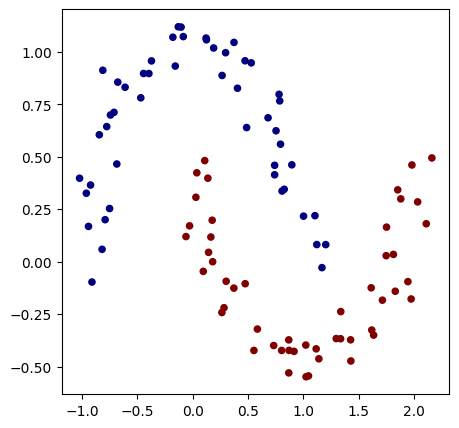

In [3]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1

print(f"{X.shape=}, {y.shape=}\n")
print(f'{X[0]=}\n')

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [4]:
# initialize a model
# remember that x had 2 features and so our input layer must have 2 neurons
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [
Layer of [reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2), reluNeuron(in:2)],
Layer of [reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16), reluNeuron(in:16)],
Layer of [linearNeuron(in:16)]
]
number of parameters 337


In [5]:
# loss function
X_value = [list(map(Value, xrow)) for xrow in X]

def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X_value, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    # convert all the inputs to Value objects. Remember we have 100 rows each with 2 features
    inputs = [list(map(Value, xrow)) for xrow in Xb] if batch_size is not None else X_value
    
    # forward the model to get scores
    # call the model on the inputs. Note the model is being called and passed each row of X (with 2 features)
    scores = list(map(model, inputs))  # model is comming from outside the function!
    
    # calculate the loss
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [6]:
total_loss.backward()
total_loss

Value(data=0.8958441028683222, grad=1)

In [ ]:
# optimization
for k in range(30):
    # forward + calculate the loss as a Value object
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100  # decaying learning rate
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.11150874481803691, accuracy 96.0%
step 1 loss 0.09885844453302561, accuracy 97.0%
step 2 loss 0.19316254022345697, accuracy 93.0%
step 3 loss 0.3007393475920763, accuracy 89.0%
step 4 loss 0.1358882381404464, accuracy 94.0%


(-1.548639298268643, 1.951360701731357)

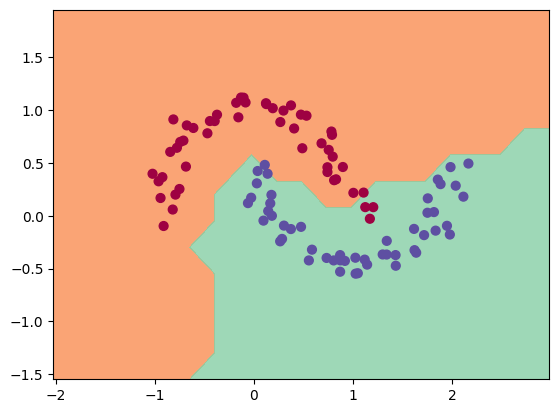

In [14]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
